In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from l2gx.patch.clustering.fennel import fennel_clustering
from l2gx.patch.clustering.fennel_rust import (
    fennel_clustering_rust, 
    is_rust_available
)
from l2gx.patch.clustering.metis import metis_clustering
from l2gx.graphs import TGraph
from l2gx.datasets import get_dataset
from scripts.test_graph_utils import generate_hidden_partition_model
from scripts.plot_test_graph import plot_graph_with_clusters, tgraph_to_networkx


# <font color="grey"> Graph Clustering</font>

In [21]:
num_nodes = 50000
num_clusters = 100

In [ ]:
tgraph, cluster_assignments = generate_hidden_partition_model(num_nodes=num_nodes, num_clusters=num_clusters, in_cluster_prob=0.8, out_cluster_prob=0.1)
print(f"Generated graph: {tgraph.num_nodes} nodes, {tgraph.num_edges} edges")


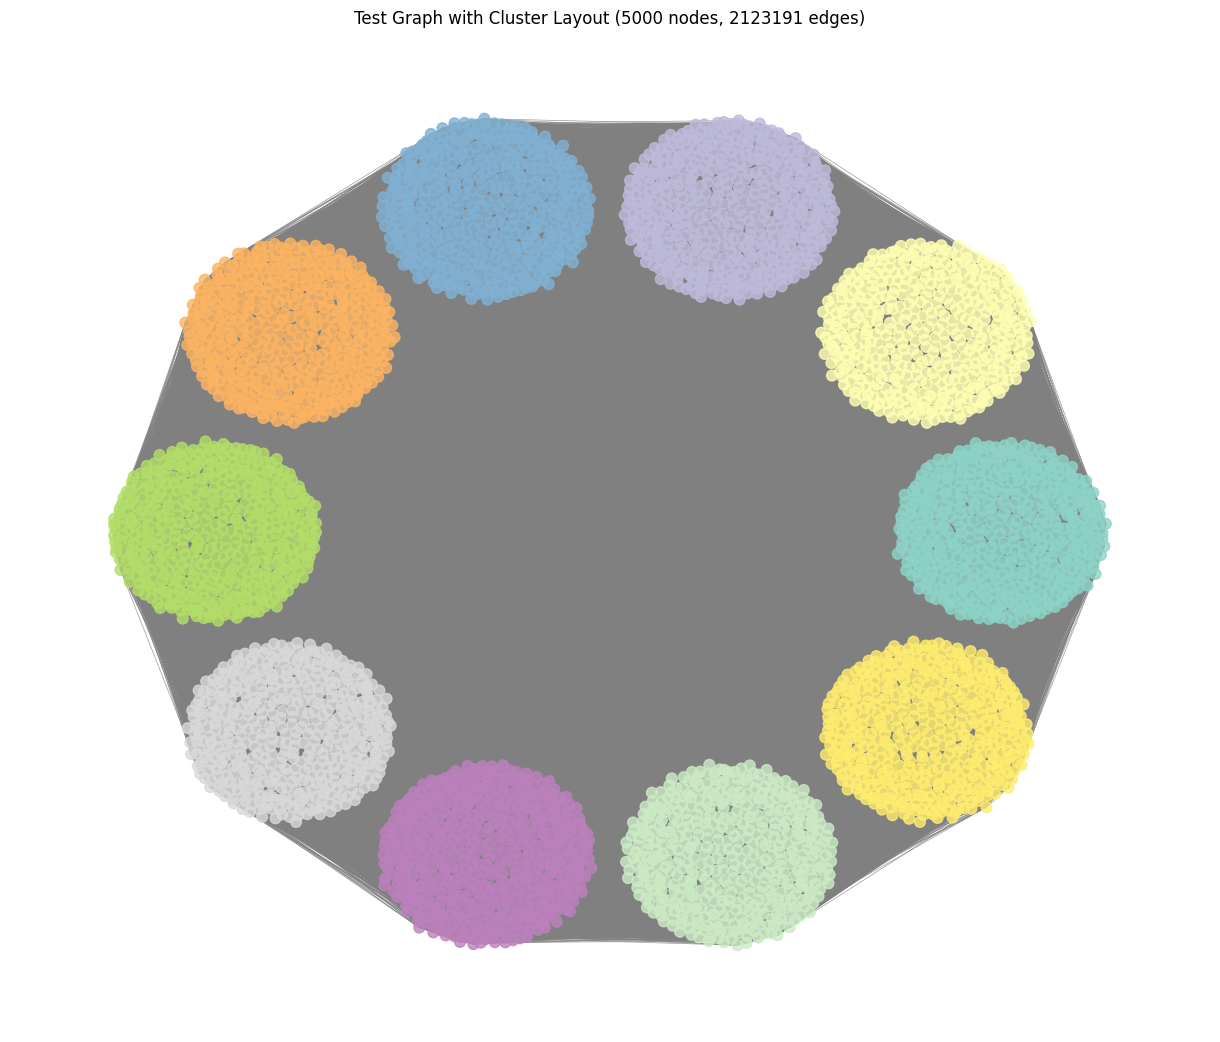

In [16]:
G = tgraph_to_networkx(tgraph)
fig = plot_graph_with_clusters(G, cluster_assignments)
plt.show()

In [17]:
python_clusters = fennel_clustering(
    tgraph,
    num_clusters,
    verbose=False
    )

Fennel iteration: 0, not converged: 5000


In [18]:
rust_clusters = fennel_clustering_rust(tgraph, num_clusters, verbose=False)

In [19]:
python_clusters

array([0, 1, 2, ..., 1, 6, 7])

In [20]:
rust_clusters

tensor([0, 1, 2,  ..., 1, 6, 7])